In [1]:
from statsmodels.tsa.stattools import adfuller
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import acf
import pmdarima as pm

from itertools import product

from tqdm.notebook import tqdm

from timezonefinder import TimezoneFinder

In [2]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [26]:
def get_history(timeseries: pd.DataFrame, timestamp: pd.Timestamp, hours_n: int) -> pd.DataFrame:
    history = timeseries[timestamp - pd.Timedelta(hours=hours_n) : timestamp - pd.Timedelta(hours=1)]
    if len(history) != hours_n:
        return None
    # print(type(history))
    return history

In [27]:
def get_actual_forecast(timeseries: pd.DataFrame, timestamp: pd.Timestamp, hours_n: int) -> pd.DataFrame:
    actual_forecast = timeseries[timestamp : timestamp  + pd.Timedelta(hours=hours_n-1)]
    if len(actual_forecast) != hours_n:
        return None
    # print(type(actual_forecast))
    return actual_forecast

In [3]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast - actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [4]:
DATA_PATH = "psh_microgrid_total_power.csv"

LATITUDE = 18.852
LONGITUDE = 98.994
TIMEZONE = TimezoneFinder().certain_timezone_at(lat=LATITUDE, lng=LONGITUDE)

TIMESTAMP_COLUMN = "timestamp"
VALUE_COLUMN = "total_power"
FEATURES = [TIMESTAMP_COLUMN, VALUE_COLUMN]

# HISTORY_LENGTH = 48
FORECAST_LENGTH = 12

In [5]:
df = pd.read_csv(DATA_PATH, usecols=[TIMESTAMP_COLUMN, VALUE_COLUMN], parse_dates=[TIMESTAMP_COLUMN])

In [6]:
df[TIMESTAMP_COLUMN] = pd.to_datetime(df[TIMESTAMP_COLUMN], utc=False)
df[TIMESTAMP_COLUMN] = df[TIMESTAMP_COLUMN].dt.tz_convert(TIMEZONE)
df = df.sort_values(by=TIMESTAMP_COLUMN)
df = df.set_index(TIMESTAMP_COLUMN)

In [7]:
timestamp_for_split = pd.Timestamp(year=2023, month=5, day=1, tz=TIMEZONE)

In [8]:
df_train = df[:timestamp_for_split]
df_test = df[timestamp_for_split:]

In [28]:
segment = get_actual_forecast(df_test, timestamp_for_split, 7*24)

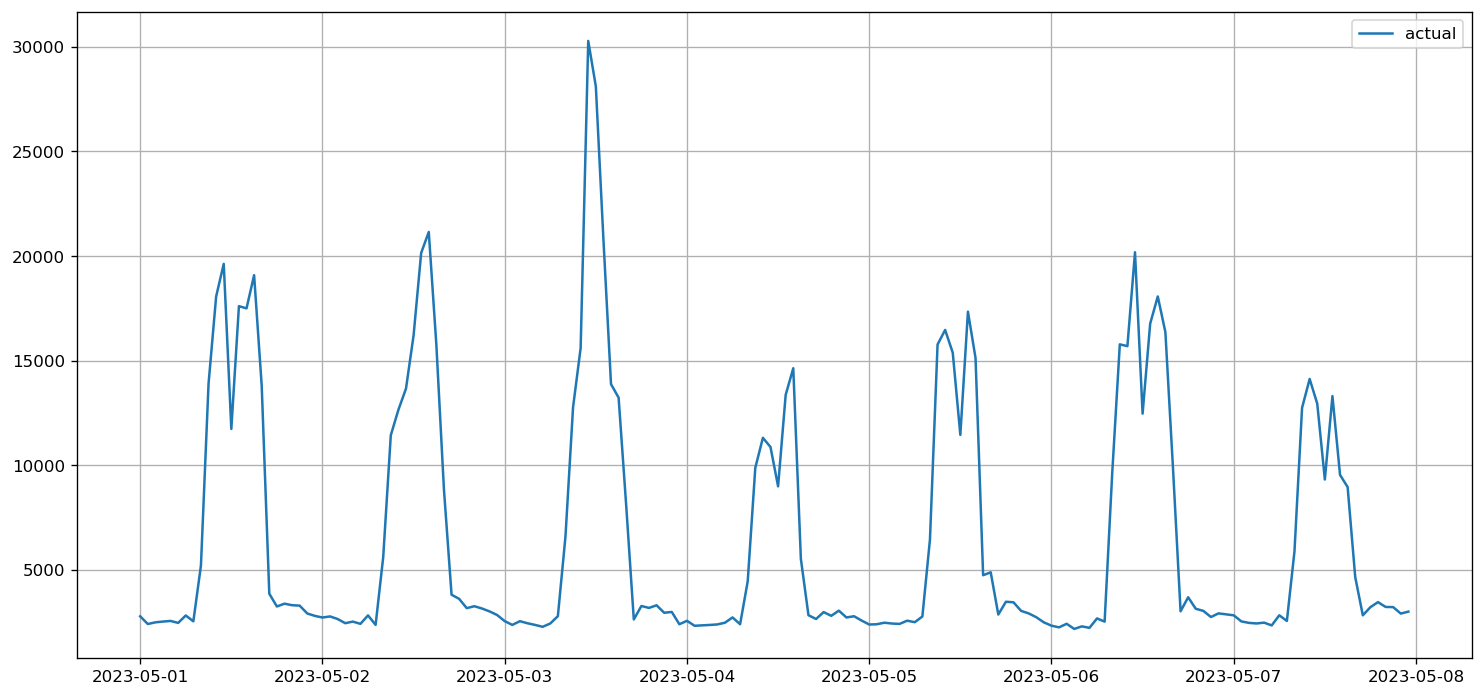

In [30]:
plt.figure(figsize=(15, 7))
# plt.plot(forecast, color="r", label="model")
# plt.axvspan(df.index[-FORECAST_HORIZON], df.index[-1], alpha=0.5, color="lightgrey")
plt.plot(segment, label="actual")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
result = adfuller(df_train[VALUE_COLUMN].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -10.622805
p-value: 0.000000


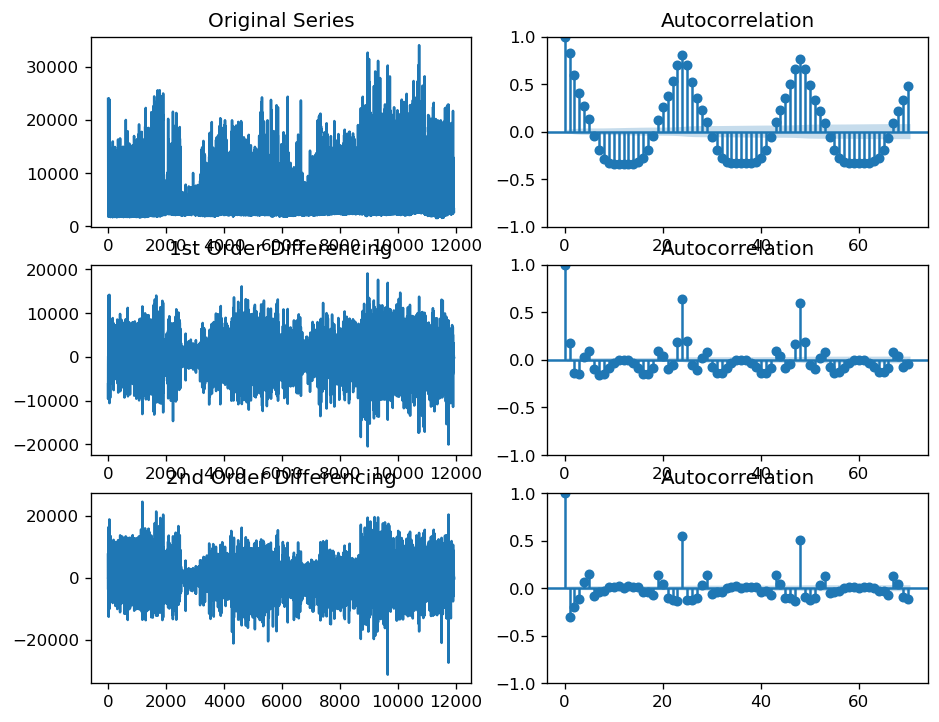

In [10]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df_train.reset_index().total_power); axes[0, 0].set_title('Original Series')
plot_acf(df_train.reset_index().total_power, ax=axes[0, 1], lags=100)

# 1st Differencing
axes[1, 0].plot(df_train.reset_index().total_power.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_train.reset_index().total_power.diff().dropna(), ax=axes[1, 1], lags=100)

# 2nd Differencing
axes[2, 0].plot(df_train.reset_index().total_power.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_train.reset_index().total_power.diff().diff().dropna(), ax=axes[2, 1], lags=100)

plt.show()

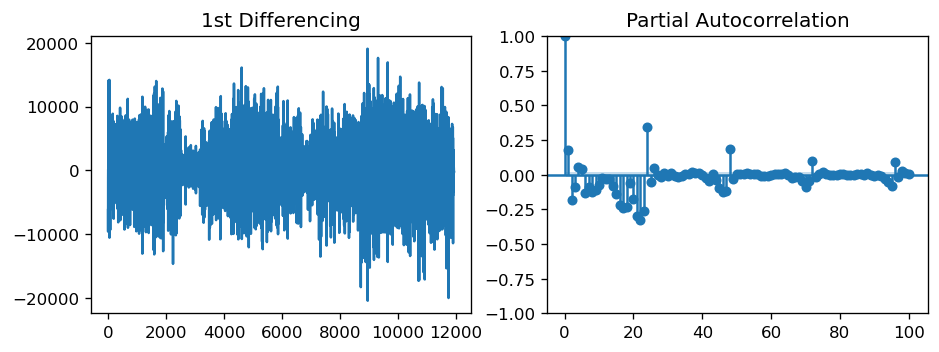

In [11]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df_train.reset_index().total_power.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df_train.reset_index().total_power.diff().dropna(), ax=axes[1], lags=100)

plt.show()

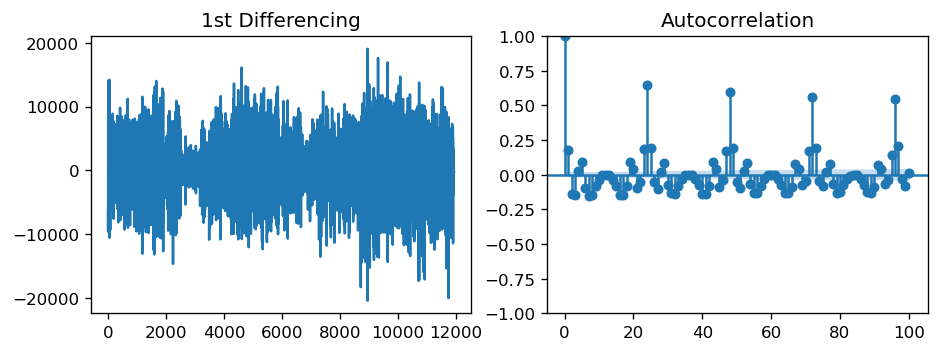

In [12]:
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df_train.reset_index().total_power.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df_train.reset_index().total_power.diff().dropna(), ax=axes[1], lags=100)

plt.show()

In [13]:
# smodel = pm.auto_arima(df_train, start_p=1, start_q=1,
#                          test='adf',
#                          max_p=25, max_q=25, m=24,
#                          start_P=0, seasonal=True,
#                          d=None, D=1, trace=True,
#                          error_action='ignore',  
#                          suppress_warnings=True, 
#                          stepwise=True)
# smodel.summary()

In [14]:
ps = range(3, 5)
d = 1
qs = range(3, 5)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)
s = 24  # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(len(parameters_list))

16


In [15]:
df_train.reset_index().total_power[7000:8000]

7000    2732.618
7001    3424.058
7002    3717.685
7003    3540.305
7004    3169.905
          ...   
7995    2484.217
7996    2436.503
7997    2405.600
7998    2523.749
7999    2507.730
Name: total_power, Length: 1000, dtype: float64

In [16]:
def optimizeSARIMA(data, parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(
                data,
                order=(param[0], d, param[1]),
                seasonal_order=(param[2], D, param[3], s),
            ).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ["parameters", "aic"]
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by="aic", ascending=True).reset_index(
        drop=True
    )
    return result_table

In [17]:
%%time
result_table = optimizeSARIMA(df_train.reset_index().total_power[7000:8000], parameters_list, d, D, s)

  0%|          | 0/16 [00:00<?, ?it/s]

/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

CPU times: user 27min 37s, sys: 51.4 s, total: 28min 28s
Wall time: 7min 8s


In [18]:
result_table

,parameters,aic
0,"(4, 4, 0, 1)",17429.839463
1,"(4, 4, 1, 1)",17440.653680
2,"(3, 4, 0, 1)",17444.086141
3,"(3, 4, 1, 1)",17445.389963
4,"(3, 3, 0, 1)",17448.940181
5,"(3, 3, 1, 1)",17450.259912
6,"(4, 3, 0, 1)",17450.882132
7,"(4, 3, 1, 1)",17452.196660
8,"(3, 3, 1, 0)",17495.770882
9,"(3, 4, 1, 0)",17515.197060


In [19]:
p, q, P, Q = result_table.parameters[0]

In [22]:
model_SARIMAX_fit = sm.tsa.statespace.SARIMAX(
    df_train.reset_index().total_power[7000:8000], 
    order=(p, d, q), 
    seasonal_order=(P, D, Q, s)
).fit(disp=-1)

/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
print(model_SARIMAX_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          total_power   No. Observations:                 1000
Model:             SARIMAX(4, 1, 4)x(0, 1, [1], 24)   Log Likelihood               -8704.920
Date:                              Tue, 10 Oct 2023   AIC                          17429.839
Time:                                      00:21:31   BIC                          17478.664
Sample:                                           0   HQIC                         17448.419
                                             - 1000                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0056      1.260      0.004      0.996      -2.463       2.475
ar.L2          0.47

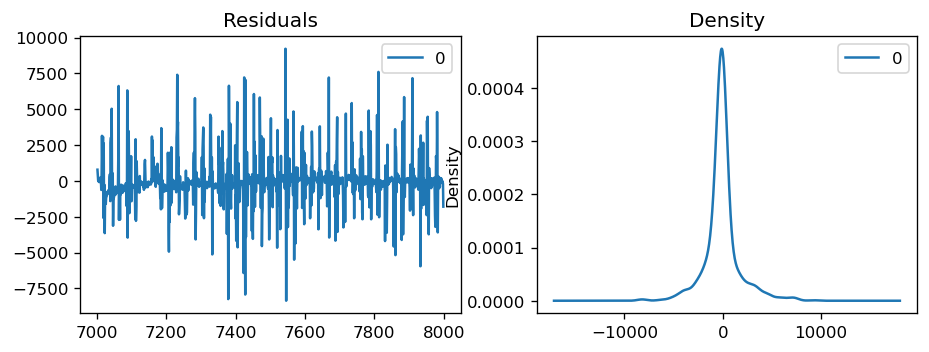

In [24]:
# Plot residual errors
residuals = pd.DataFrame(model_SARIMAX_fit.resid[2:])
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

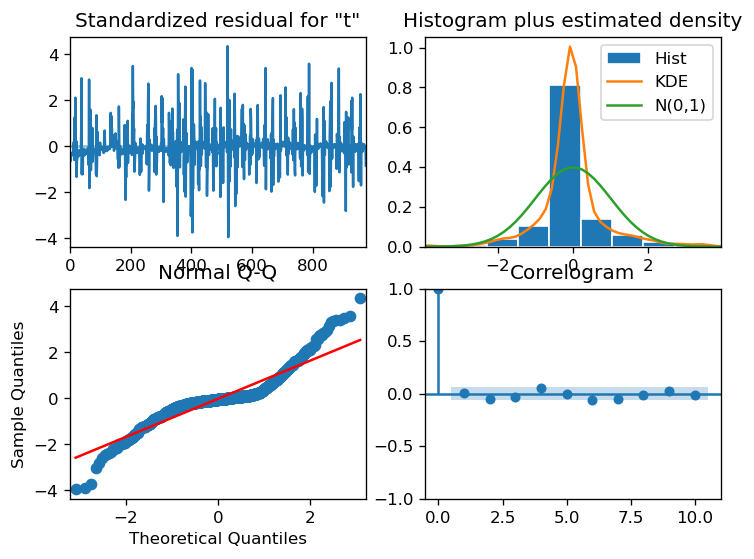

In [25]:
model_SARIMAX_fit.plot_diagnostics(figsize=(7,5))
plt.show()

In [32]:
history = get_history(segment, pd.Timestamp(year=2023, month=5, day=7, tz=TIMEZONE), 6*24)

In [34]:
history = history.reset_index().total_power

In [37]:
model_SARIMAX_fit = sm.tsa.statespace.SARIMAX(
    history, 
    order=(p, d, q), 
    seasonal_order=(P, D, Q, s)
).fit(disp=-1)

/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


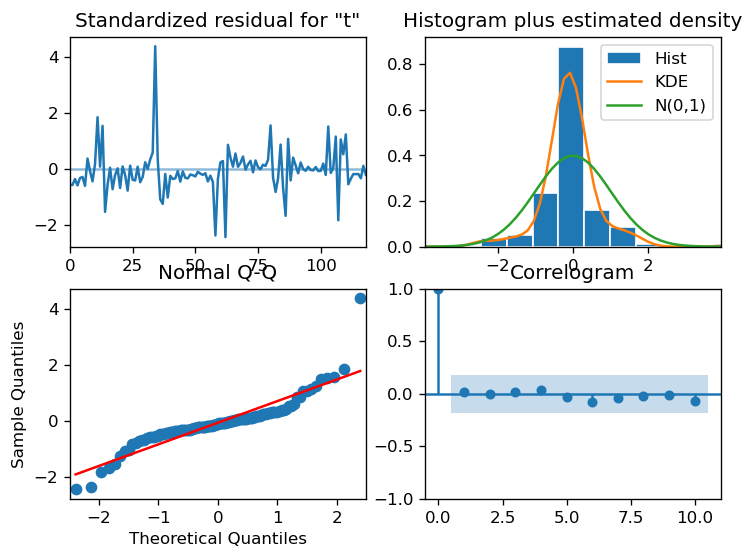

In [38]:
model_SARIMAX_fit.plot_diagnostics(figsize=(7,5))
plt.show()

In [39]:
modeling_results = model_SARIMAX_fit.fittedvalues

In [40]:
forecast = model_SARIMAX_fit.predict(start=modeling_results.shape[0], 
                             end=modeling_results.shape[0]+24)

In [41]:
modeling_results = pd.concat([modeling_results, forecast])

In [42]:
# actual_data = pd.concat([df, df_test])

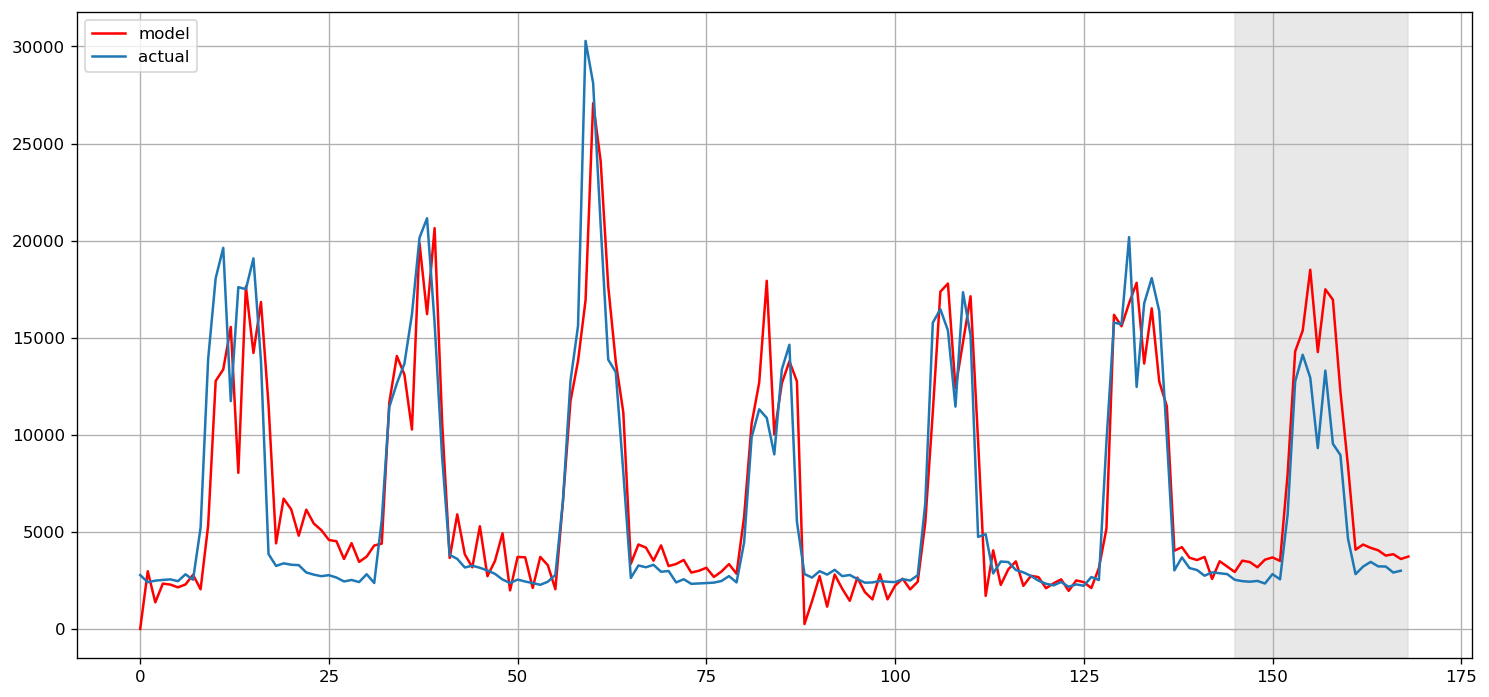

In [43]:
plt.figure(figsize=(15, 7))
# plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
plt.plot(modeling_results, color="r", label="model")
plt.axvspan(modeling_results.index[-24], modeling_results.index[-1], alpha=0.5, color="lightgrey")
plt.plot(segment.reset_index().total_power, label="actual")
plt.legend()
plt.grid(True)

In [45]:
forecast_accuracy(forecast[:-1], segment.reset_index().total_power[-24:])

/tmp/ipykernel_6124/1906257412.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
/tmp/ipykernel_6124/1906257412.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
/tmp/ipykernel_6124/1906257412.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
/tmp/ipykernel_6124/1906257412.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 

{'mape': 0.34910321666608796,
 'me': 1942.9363480472302,
 'mae': 1942.9363480472302,
 'mpe': 0.34910321666608796,
 'rmse': 2681.3558588772767,
 'acf1': 0.6268502758546566,
 'corr': 0.9656618672054491,
 'minmax': 0.24659876755502486}